Works fine in 

Tensorflow: 2.2.0<br>
Keras: 2.4.3<br>
dataset: https://finance.yahoo.com/quote/GE/history/<br>
Also try S&P: https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC

Help : https://www.youtube.com/watch?v=6S2v7G-OupA

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns

In [4]:
dataframe = pd.read_csv('GE.csv')
df = dataframe[['Date', 'Close']]
df['Date'] = pd.to_datetime(df['Date'])
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,Close
0,2020-05-04,6.21
1,2020-05-05,6.20
2,2020-05-06,5.98
3,2020-05-07,6.11
4,2020-05-08,6.29
...,...,...
247,2021-04-27,13.49
248,2021-04-28,13.20
249,2021-04-29,13.21
250,2021-04-30,13.12


Start date is:  2020-05-04 00:00:00
End date is:  2021-05-03 00:00:00


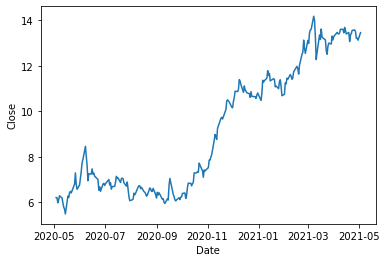

In [3]:
sns.lineplot(x=df['Date'], y=df['Close'])
print("Start date is: ", df['Date'].min())
print("End date is: ", df['Date'].max())

In [5]:
#Change train data from Mid 2017 to 2019.... seems to be a jump early 2017
train, test = df.loc[df['Date'] <= '2021-1-31'], df.loc[df['Date'] > '2021-1-31']


In [6]:
#Convert pandas dataframe to numpy array
#dataset = dataframe.values
#dataset = dataset.astype('float32') #COnvert values to float

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = MinMaxScaler() #Also try QuantileTransformer

In [7]:
scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [8]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 2. We will make timesteps = 3. 
#With this, the resultant n_samples is 5 (as the input data has 9 rows).
seq_size = 30  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

In [9]:
def to_sequences(x, y, seq_size=1):
    x_values = []
    y_values = []

    for i in range(len(x)-seq_size):
        #print(i)
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])
        
    return np.array(x_values), np.array(y_values)

trainX, trainY = to_sequences(train[['Close']], train['Close'], seq_size)
testX, testY = to_sequences(test[['Close']], test['Close'], seq_size)

In [10]:
# define Autoencoder model
#Input shape would be seq_size, 1 - 1 beacuse we have 1 feature. 
# seq_size = trainX.shape[1]

# model = Sequential()
# model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
# model.add(LSTM(64, activation='relu', return_sequences=False))
# model.add(RepeatVector(trainX.shape[1]))
# model.add(LSTM(64, activation='relu', return_sequences=True))
# model.add(LSTM(128, activation='relu', return_sequences=True))
# model.add(TimeDistributed(Dense(trainX.shape[2])))

# model.compile(optimizer='adam', loss='mse')
# model.summary()

In [11]:
#Try another model
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(rate=0.2))

model.add(RepeatVector(trainX.shape[1]))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(trainX.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

In [12]:
# fit model
history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/10
5/5 [==============================] - 5s 379ms/step - loss: 0.6759 - val_loss: 0.5129
Epoch 2/10
5/5 [==============================] - 0s 90ms/step - loss: 0.3071 - val_loss: 0.3897
Epoch 3/10
5/5 [==============================] - 0s 81ms/step - loss: 0.2366 - val_loss: 0.2922
Epoch 4/10
5/5 [==============================] - 0s 81ms/step - loss: 0.1993 - val_loss: 0.2371
Epoch 5/10
5/5 [==============================] - 0s 85ms/step - loss: 0.1817 - val_loss: 0.2549
Epoch 6/10
5/5 [==============================] - 0s 79ms/step - loss: 0.1709 - val_loss: 0.2071
Epoch 7/10
5/5 [==============================] - 0s 89ms/step - loss: 0.1630 - val_loss: 0.2022
Epoch 8/10
5/5 [==============================] - 0s 96ms/step - loss: 0.1548 - val_loss: 0.1924
Epoch 9/10
5/5 [==============================] - 0s 94ms/step - loss: 0.1555 - val_loss: 0.2454
Epoch 10/10
5/5 [==============================] - 0s 85ms/step - loss: 0.1544 - val_loss: 0.1800


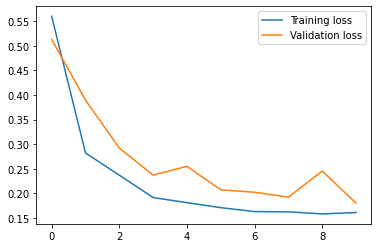

In [13]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [14]:
model.evaluate(testX, testY)

2/2 [==============================] - 0s 12ms/step - loss: 0.5338


0.5337725877761841

(array([11., 18., 20., 11., 20., 13., 11.,  4.,  3.,  5.,  6.,  2.,  5.,
         2.,  1.,  0.,  2.,  0.,  1.,  0.,  1.,  2.,  3.,  5.,  1.,  1.,
         1.,  2.,  4.,  3.]),
 array([0.07426065, 0.1081513 , 0.14204196, 0.17593261, 0.20982327,
        0.24371392, 0.27760457, 0.31149523, 0.34538588, 0.37927654,
        0.41316719, 0.44705785, 0.4809485 , 0.51483915, 0.54872981,
        0.58262046, 0.61651112, 0.65040177, 0.68429242, 0.71818308,
        0.75207373, 0.78596439, 0.81985504, 0.85374569, 0.88763635,
        0.921527  , 0.95541766, 0.98930831, 1.02319896, 1.05708962,
        1.09098027]),
 <a list of 30 Patch objects>)

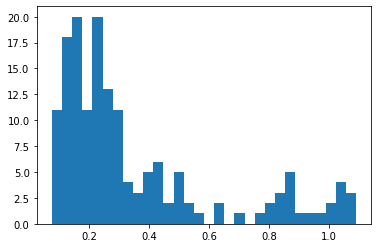

In [15]:
#Anomaly is where reconstruction error is large.
#We can define this value beyond which we call anomaly.
#Let us look at MAE in training prediction

trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
plt.hist(trainMAE, bins=30)

(array([1., 6., 1., 3., 2., 2., 0., 2., 1., 1., 3., 3., 3., 0., 0., 0., 1.,
        0., 0., 2., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.]),
 array([0.43470261, 0.43808955, 0.44147649, 0.44486343, 0.44825038,
        0.45163732, 0.45502426, 0.45841121, 0.46179815, 0.46518509,
        0.46857203, 0.47195898, 0.47534592, 0.47873286, 0.4821198 ,
        0.48550675, 0.48889369, 0.49228063, 0.49566758, 0.49905452,
        0.50244146, 0.5058284 , 0.50921535, 0.51260229, 0.51598923,
        0.51937617, 0.52276312, 0.52615006, 0.529537  , 0.53292395,
        0.53631089]),
 <a list of 30 Patch objects>)

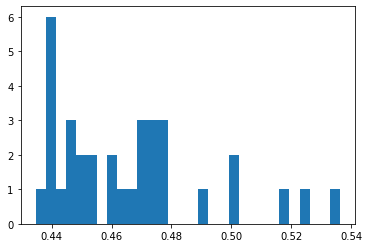

In [16]:
testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
plt.hist(testMAE, bins=30)

In [18]:
#Capture all details in a DataFrame for easy plotting
max_trainMAE = 0.3  #or Define 90% value of max as threshold.
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomaly_df['Close'] = test[seq_size:]['Close']

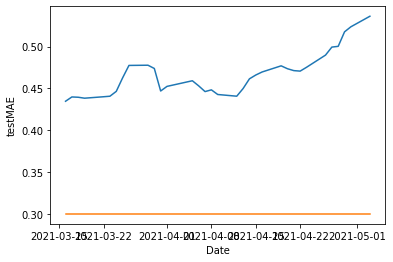

In [19]:
#Plot testMAE vs max_trainMAE
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['testMAE'])
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['max_trainMAE'])

In [20]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]

In [ ]:
#Plot anomalies
sns.lineplot(x=anomaly_df['Date'], y=scaler.inverse_transform(anomaly_df['Close']))
sns.scatterplot(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['Close']), color='r')

--------------------------------